In [2]:
#import libraries
import pandas as pd
import numpy as np

import flexcode
from flexcode.regression_models import CustomModel

from xgboost import XGBRegressor, plot_importance, plot_tree

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import cdetools
from cdetools.cde_loss import cde_loss
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band

In [3]:
def plot_cde_range(cdes, y_test, zgrid, val_range, shape, subset=None, roi=True):
    """
    Function to plot CDES from FlexCode.
    
    cdes: array
            list of cdes as recieved from flexcode model predictions
        
    y_test: array MUST BE SERIES OR PANDAS DATAFRAME
            list of target variables corresponding to the passed cdes
            
    zgrid: listlike
            zgrid as passed from flexcode
    
    val_range: list/tuple consisting of a range as such -> (start,finish)
            this defines the cdes you want to look at based on their corresponding target var
            i.e. look at cdes where target var between 0 and 0.06 -> (0,0.06)
            
    shape: tuple, list in form of -> (nrows, ncols)
            the shape the subplots will be plotted into when viewing cdes
    
    subset: tuple, list like -> (start, finish) default:None
            the subset of all cdes inside val range to plot i.e. the 3rd to 10th cdes
    
    roi: boolean default:True
            whether or not to plot a vertical green line at 0.06 (this is roi for redshifts we are looking at)
    """
    lwr = val_range[0]
    upr = val_range[1]
    nrows = shape[0]
    ncols = shape[1]
    
    zVals = y_test.reset_index(drop=True)
    if type(zVals) == pd.core.frame.DataFrame:
        test_inds = zVals.query("z>@lwr & z<@upr").index.values.tolist()
    else:
        zVals = zVals.to_frame()
        test_inds = zVals.query("z>@lwr & z<@upr").index.values.tolist()
    n_tests = len(test_inds) # list of indices of zVals within target range 

    if subset != None:
        #if start point > list no points to plot
        if subset[0] > n_tests:
            raise IndexError("No Values in Range")
            #else if end point 
        elif subset[1] > n_tests:
            subset[1] = n_tests
        test_inds = test_inds[subset[0]:subset[1]]
        n_tests = len(test_inds)
    
    fig = plt.figure(figsize=(40, 20))

    for plotNum in range(nrows*ncols):
        if plotNum == n_tests:
            break
        cde = cdes[test_inds[plotNum]]
        trueZ = zVals.iloc[test_inds[plotNum]][0]

        ax = fig.add_subplot(nrows, ncols, plotNum+1)
        
        if roi == True:
            plt.axvline(0.06, color='green', label=r'$GW Thresh$', alpha=0.8)
            
        plt.plot(zgrid, cde, label=r'$\hat{p}(z| x_{\rm obs})$')
        plt.axvline(trueZ, color='red', label=r'$z_{\rm obs}$')
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r'Redshift $z$', size=20)
        plt.ylabel('CDE', size=20)
        plt.xlim(0,1)
        plt.legend(loc='upper right', prop={'size': 20})
    plt.show()
    return

In [4]:
all_data = pd.read_csv("Teddy_custom.csv")
data = pd.read_csv("Teddy_custom_undersamp.csv")

In [23]:
all_data.query("z>1")

rMagNormPS    ugNorm  grNormPS  riNormPS  izNormPS  zyNormPS  \
1170      0.882274 -1.498294  0.901522  0.906351  0.617888 -1.085003   
3056      0.552121  0.241113 -0.426228 -0.702645 -0.231224  1.466409   
4115     -0.148579 -0.470091  1.116613  0.291715 -0.153330 -0.764282   
9728     -0.457381 -0.276808  1.037859  0.289211 -0.255767 -0.256583   
12074     0.894588  0.310139 -0.043197  1.245850  1.165630 -1.227389   
...            ...       ...       ...       ...       ...       ...   
282968    1.653664  0.120229 -0.186768  2.320190 -0.310797 -1.825695   
287375    1.726481 -0.236450 -2.643797  1.821249 -2.186799  2.471724   
287814    1.612828  0.284658  0.542059  1.160853  2.182365 -0.718264   
292184   -0.020574  0.938413  0.980005  0.041751  0.835454 -0.099096   
293879    1.570750  0.826815 -0.885335  2.074744 -0.567310  0.865236   

          yjNorm    jhNorm    hkNorm  rMagErrNorm  ugErrNorm  grErrNorm  \
1170         NaN       NaN       NaN     0.488982  -0.161827   0.481363   
3056         NaN       NaN       NaN    -0.160483  -0.485073  -0.304671   
4115         NaN       NaN       NaN    -0.219437  -0.191650  -0.293504   
9728    0.057874 -0.125850  0.318548    -0.494960  -0.555622  -0.517956   
12074        NaN       NaN       NaN     0.643697   1.468506   1.187915   
...          ...       ...       ...          ...        ...        ...   
282968       NaN       NaN       NaN     2.065608   5.484562   2.745731   
287375       NaN       NaN       NaN     6.651083   0.558666   1.706425   
287814       NaN       NaN       NaN     0.958684   2.829335   1.693308   
292184  0.331667 -0.575458  1.911856    -0.381401   0.671576  -0.269474   
293879       NaN       NaN       NaN     1.036082   2.067401   0.909702   

        riErrNorm  izErrNorm  zyErrNorm  yjErrNorm  jhErrNorm  hkErrNorm  \
1170     0.798653   0.852125   1.003399        NaN        NaN        NaN   
3056    -0.047909   0.112646   0.212889        NaN        NaN        NaN   
4115    -0.253470  -0.462147  -0.575760        NaN        NaN        NaN   
9728    -0.539057  -0.558516  -0.630487  -0.285869  -0.066608   0.192047   
12074    0.718109   0.953768   0.728199        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
282968   2.129656   1.851936   3.300856        NaN        NaN        NaN   
287375   6.016283   3.053361   2.248739        NaN        NaN        NaN   
287814   1.251794   1.573197   1.211881        NaN        NaN        NaN   
292184  -0.409248  -0.305390  -0.273219   1.024368   1.479348   0.943174   
293879   1.111863   1.309073   0.967851        NaN        NaN        NaN   

               z  
1170    1.686932  
3056    1.274839  
4115    1.484491  
9728    1.412565  
12074   6.560494  
...          ...  
282968  1.520873  
287375  1.241523  
287814  1.896334  
292184  1.704757  
293879  6.066194  

[71 rows x 19 columns]

In [24]:
data.query("z>1")

Empty DataFrame
Columns: [rMagNormPS, ugNorm, grNormPS, riNormPS, izNormPS, zyNormPS, yjNorm, jhNorm, hkNorm, rMagErrNorm, ugErrNorm, grErrNorm, riErrNorm, izErrNorm, zyErrNorm, yjErrNorm, jhErrNorm, hkErrNorm, z]
Index: []

In [5]:
data

rMagNormPS    ugNorm  grNormPS  riNormPS  izNormPS  zyNormPS  \
0        -0.537284  0.005719 -0.728640 -0.482842  0.103167  0.356824   
1         1.609195 -0.256683  0.061265  2.043057  0.881166 -1.918457   
2        -0.106146  0.505426 -0.018828  0.243940  0.566249  0.588378   
3        -0.471113 -0.427609 -2.355583 -1.499344 -0.693451  0.207237   
4        -1.222660  0.076330 -0.947740 -0.964687  0.673757  1.050759   
...            ...       ...       ...       ...       ...       ...   
113319   -0.835547  0.464406  1.208752 -2.626993  2.222135  0.348910   
113320    1.550907  0.163572  0.726614  2.461529 -2.773488  1.834601   
113321   -0.124395  0.132146  0.488763  0.689062  0.364766  0.323741   
113322    1.631341  4.074472 -0.005432  0.997382  0.670382  0.309353   
113323    1.381002 -2.679056  1.127592  1.890657  2.166266 -0.271685   

          yjNorm    jhNorm    hkNorm  rMagErrNorm  ugErrNorm  grErrNorm  \
0       0.534008 -0.515510 -2.655080    -0.559311  -0.904732  -0.587382   
1            NaN       NaN       NaN     2.545539   0.911050   2.379588   
2      -0.071261 -0.005955  1.178689    -0.580009  -0.199123  -0.520997   
3            NaN       NaN       NaN    -0.462906  -1.020007  -0.754181   
4      -1.257498 -0.562611  0.089178    -0.570425  -0.942910  -0.759662   
...          ...       ...       ...          ...        ...        ...   
113319 -0.814742  1.514154  0.511055    -0.705489  -0.215531  -0.352872   
113320       NaN       NaN       NaN     2.524519   2.056433   2.110203   
113321  0.334303 -0.228619  1.334334    -0.475873  -0.186018  -0.443794   
113322       NaN       NaN       NaN     1.619182   0.184976   2.178644   
113323       NaN       NaN       NaN     1.129587  -0.117455   2.057416   

        riErrNorm  izErrNorm  zyErrNorm  yjErrNorm  jhErrNorm  hkErrNorm  \
0       -0.577842  -0.730879  -0.808765  -0.201674  -0.049792   1.228139   
1        2.363053   1.162976   0.862231        NaN        NaN        NaN   
2       -0.562239  -0.333279  -0.355203   0.294827   0.564636   0.334215   
3       -0.428719  -0.215222  -0.180505        NaN        NaN        NaN   
4       -0.658812  -0.872458  -0.882531  -0.613550  -0.528280  -0.463925   
...           ...        ...        ...        ...        ...        ...   
113319  -0.717478  -0.530775  -0.450133   0.132813  -0.461584  -0.814614   
113320   2.324640   1.724743   2.137546        NaN        NaN        NaN   
113321  -0.504731  -0.498372  -0.511843  -0.278292  -0.394954  -0.264581   
113322   1.586097   1.844955   1.765977        NaN        NaN        NaN   
113323   1.112127   0.981841   0.586451        NaN        NaN        NaN   

               z  
0       0.159820  
1       0.507417  
2       0.246482  
3       0.082204  
4       0.081735  
...          ...  
113319  0.258979  
113320  0.582979  
113321  0.261855  
113322  0.498760  
113323  0.522893  

[113324 rows x 19 columns]

In [6]:
x = data.drop("z", axis=1)
y = data["z"]

In [7]:
test_size = 0.4
random_state = 7

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_state)

In [9]:
y_train = y_train.values
y_test = y_test.values

<Axes: ylabel='Count'>

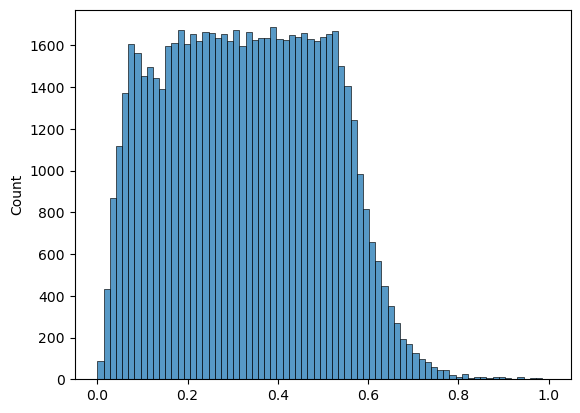

In [12]:
sns.histplot(y_train)

In [9]:
x_train

rMagNormPS    ugNorm  grNormPS  riNormPS  izNormPS  zyNormPS  \
95067     2.041839  0.922724  0.111087  1.947488  0.860853  1.055806   
39252    -0.993581  0.588709 -0.324177 -0.530627 -0.214302  1.036384   
112696    1.293837  2.156560  2.017401  2.147174  0.979373  0.331655   
102637    1.669875  0.315928  0.866434  0.470784 -0.785731  1.630370   
15874     1.406692  1.203896 -1.197653  0.379744 -0.023814  0.230980   
...            ...       ...       ...       ...       ...       ...   
104003    1.309339  0.917412 -0.364359  0.586969  0.037141 -0.065300   
10742     1.906218  0.966575 -0.244090  2.226137  1.986807  0.567516   
49689     1.555955  2.665305  1.248663  2.076749  0.264880 -0.381001   
58564    -1.572832 -0.965223 -3.191288 -1.700535 -1.379170  0.017394   
61615    -0.405471  0.135472  0.197601 -0.526607  0.201389 -0.082568   

          yjNorm    jhNorm    hkNorm  rMagErrNorm  ugErrNorm  grErrNorm  \
95067        NaN       NaN       NaN     3.352457   1.193057   3.140878   
39252  -1.324264  1.411393  0.179285    -0.758483  -0.668568  -0.779928   
112696       NaN       NaN       NaN     1.424440   1.797481   3.772078   
102637       NaN       NaN       NaN     1.871269   3.896196   2.160596   
15874        NaN       NaN       NaN     1.448118   1.364716   1.793672   
...          ...       ...       ...          ...        ...        ...   
104003       NaN       NaN       NaN     0.768532   1.715725   0.444702   
10742        NaN       NaN       NaN     1.722111   1.385648   1.614109   
49689        NaN       NaN       NaN     1.326746   1.485238   1.687415   
58564  -1.371112 -0.716768 -1.262471    -0.836767  -1.214368  -0.956501   
61615   0.399309 -0.883760  1.575992    -0.467416  -0.631191  -0.335108   

        riErrNorm  izErrNorm  zyErrNorm  yjErrNorm  jhErrNorm  hkErrNorm  
95067    3.242454   2.080872   1.494222        NaN        NaN        NaN  
39252   -0.787553  -0.958678  -0.941472  -0.114525  -0.081628  -0.542783  
112696   1.497564   1.585440   1.302795        NaN        NaN        NaN  
102637   1.812429   2.308526   2.019937        NaN        NaN        NaN  
15874    1.457820   1.221967   1.237314        NaN        NaN        NaN  
...           ...        ...        ...        ...        ...        ...  
104003   0.800226   1.173122   0.851830        NaN        NaN        NaN  
10742    1.572220   1.048675   0.923047        NaN        NaN        NaN  
49689    1.304984   0.860980   0.496680        NaN        NaN        NaN  
58564   -0.933430  -1.079572  -0.900678  -0.612560  -0.411009   0.327602  
61615   -0.511484  -0.686394  -0.659657  -0.533621   0.055386   0.146922  

[67994 rows x 18 columns]

## 2 Scenarios
1) Just PS + UMag vs PS + UMag + 2MASS
2) As above but with errors included

### Scenario 1

Training Set Creation

In [10]:
ps_train = x_train[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS"]]
ps_test = x_test[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS"]]

In [11]:
ps2m_train = x_train[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS","yjNorm","jhNorm","hkNorm"]]
ps2m_test = x_test[["rMagNormPS","ugNorm","grNormPS","riNormPS","izNormPS","zyNormPS","yjNorm","jhNorm","hkNorm"]]

Fitting the Models

In [12]:
regression_params = {"max_depth":5}

In [13]:
psModel = flexcode.FlexCodeModel(CustomModel, max_basis=30, basis_system="cosine", custom_model=XGBRegressor, regression_params=regression_params)
psModel.fit(ps_train, y_train)

In [14]:
ps2mModel = flexcode.FlexCodeModel(CustomModel, max_basis=30, basis_system="cosine", custom_model=XGBRegressor, regression_params=regression_params)
ps2mModel.fit(ps2m_train, y_train)

Model Predictions

In [15]:
#resolution of cdes
n_grid = 1000

### PS Model Evaluation

In [16]:
#ps model
ps_cdes, ps_zgrid = psModel.predict(ps_test, n_grid=n_grid)


In [17]:
psmodel_loss, std_psModel_loss = cde_loss(ps_cdes, ps_zgrid, y_test)

In [18]:
psModel_pitVals = cdf_coverage(ps_cdes, ps_zgrid, y_test)
psModel_hpdVals = hpd_coverage(ps_cdes, ps_zgrid, y_test)

### PS 2MASS Model Evaluation

In [19]:
#ps+2mass model
ps2m_cdes, ps2m_zgrid = ps2mModel.predict(ps2m_test, n_grid=n_grid)

In [20]:
ps2mModel_loss, std_ps2mModel_loss = cde_loss(ps2m_cdes, ps2m_zgrid, y_test)

In [21]:
ps2mModel_pitVals = cdf_coverage(ps2m_cdes, ps2m_zgrid, y_test)
ps2mModel_hpdVals = hpd_coverage(ps2m_cdes, ps2m_zgrid, y_test)

### Metrics

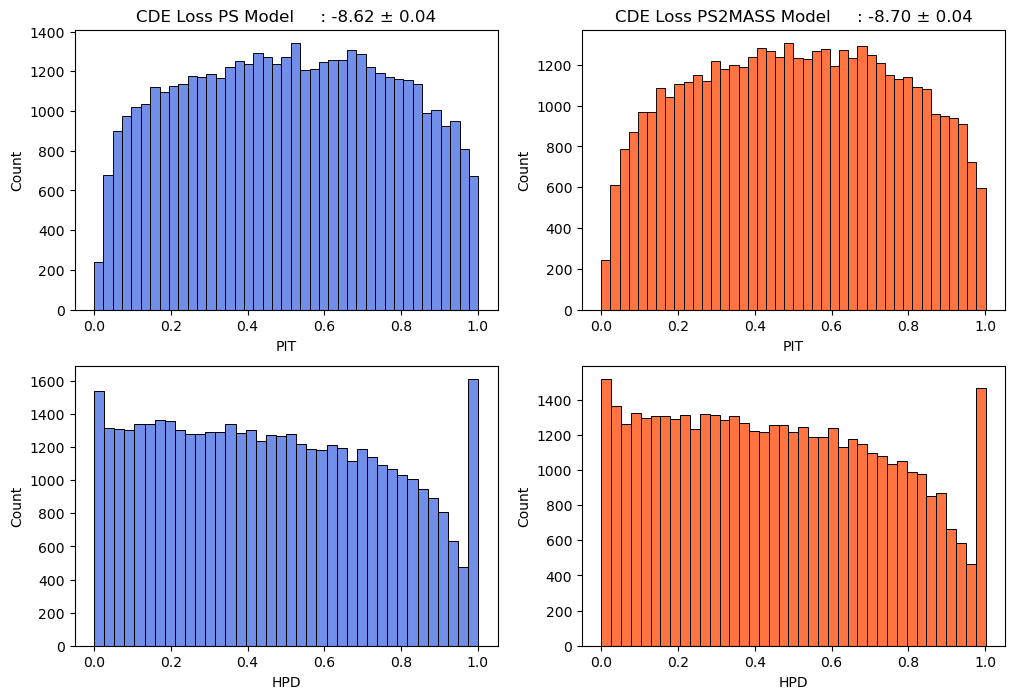

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

axs[0][0].set_title(('CDE Loss PS Model     : %4.2f ± %.2f' % (psmodel_loss, std_psModel_loss)))
sns.histplot(psModel_pitVals, ax=axs[0][0], color="royalblue")
sns.histplot(psModel_hpdVals, ax=axs[1][0], color="royalblue")
axs[0][0].set_xlabel("PIT")
axs[1][0].set_xlabel("HPD")

axs[0][1].set_title(('CDE Loss PS2MASS Model     : %4.2f ± %.2f' % (ps2mModel_loss, std_ps2mModel_loss)))
sns.histplot(ps2mModel_pitVals, ax=axs[0][1], color="orangered")
sns.histplot(ps2mModel_hpdVals, ax=axs[1][1], color="orangered")
axs[0][1].set_xlabel("PIT")
axs[1][1].set_xlabel("HPD")

plt.show()

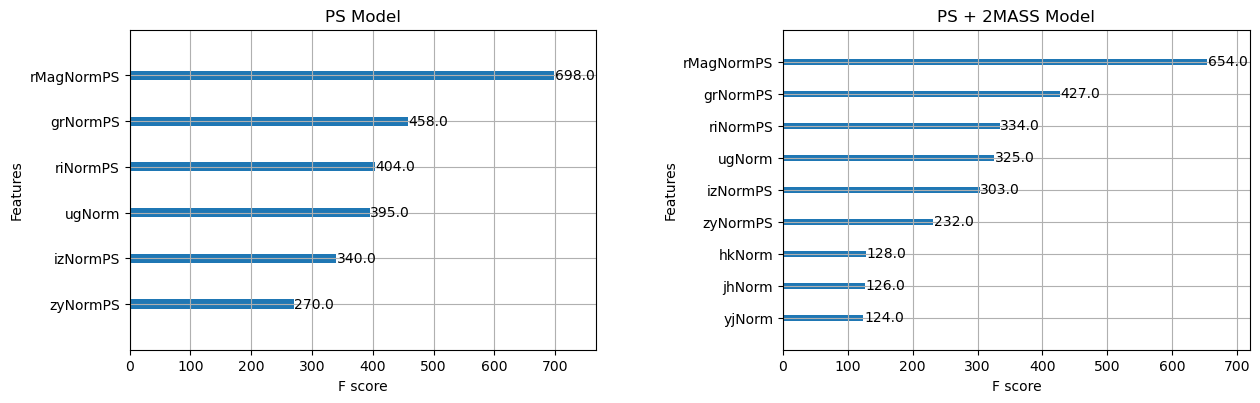

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=[14,4])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plot_importance(psModel.model.models.estimators_[2], importance_type="weight" , ax=axs[0])
plot_importance(ps2mModel.model.models.estimators_[2], importance_type="weight" , ax=axs[1])

axs[0].set_title("PS Model")
axs[1].set_title("PS + 2MASS Model")

plt.show()

### Sample CDEs from PS Model

Target Variable Between 0 - 0.06

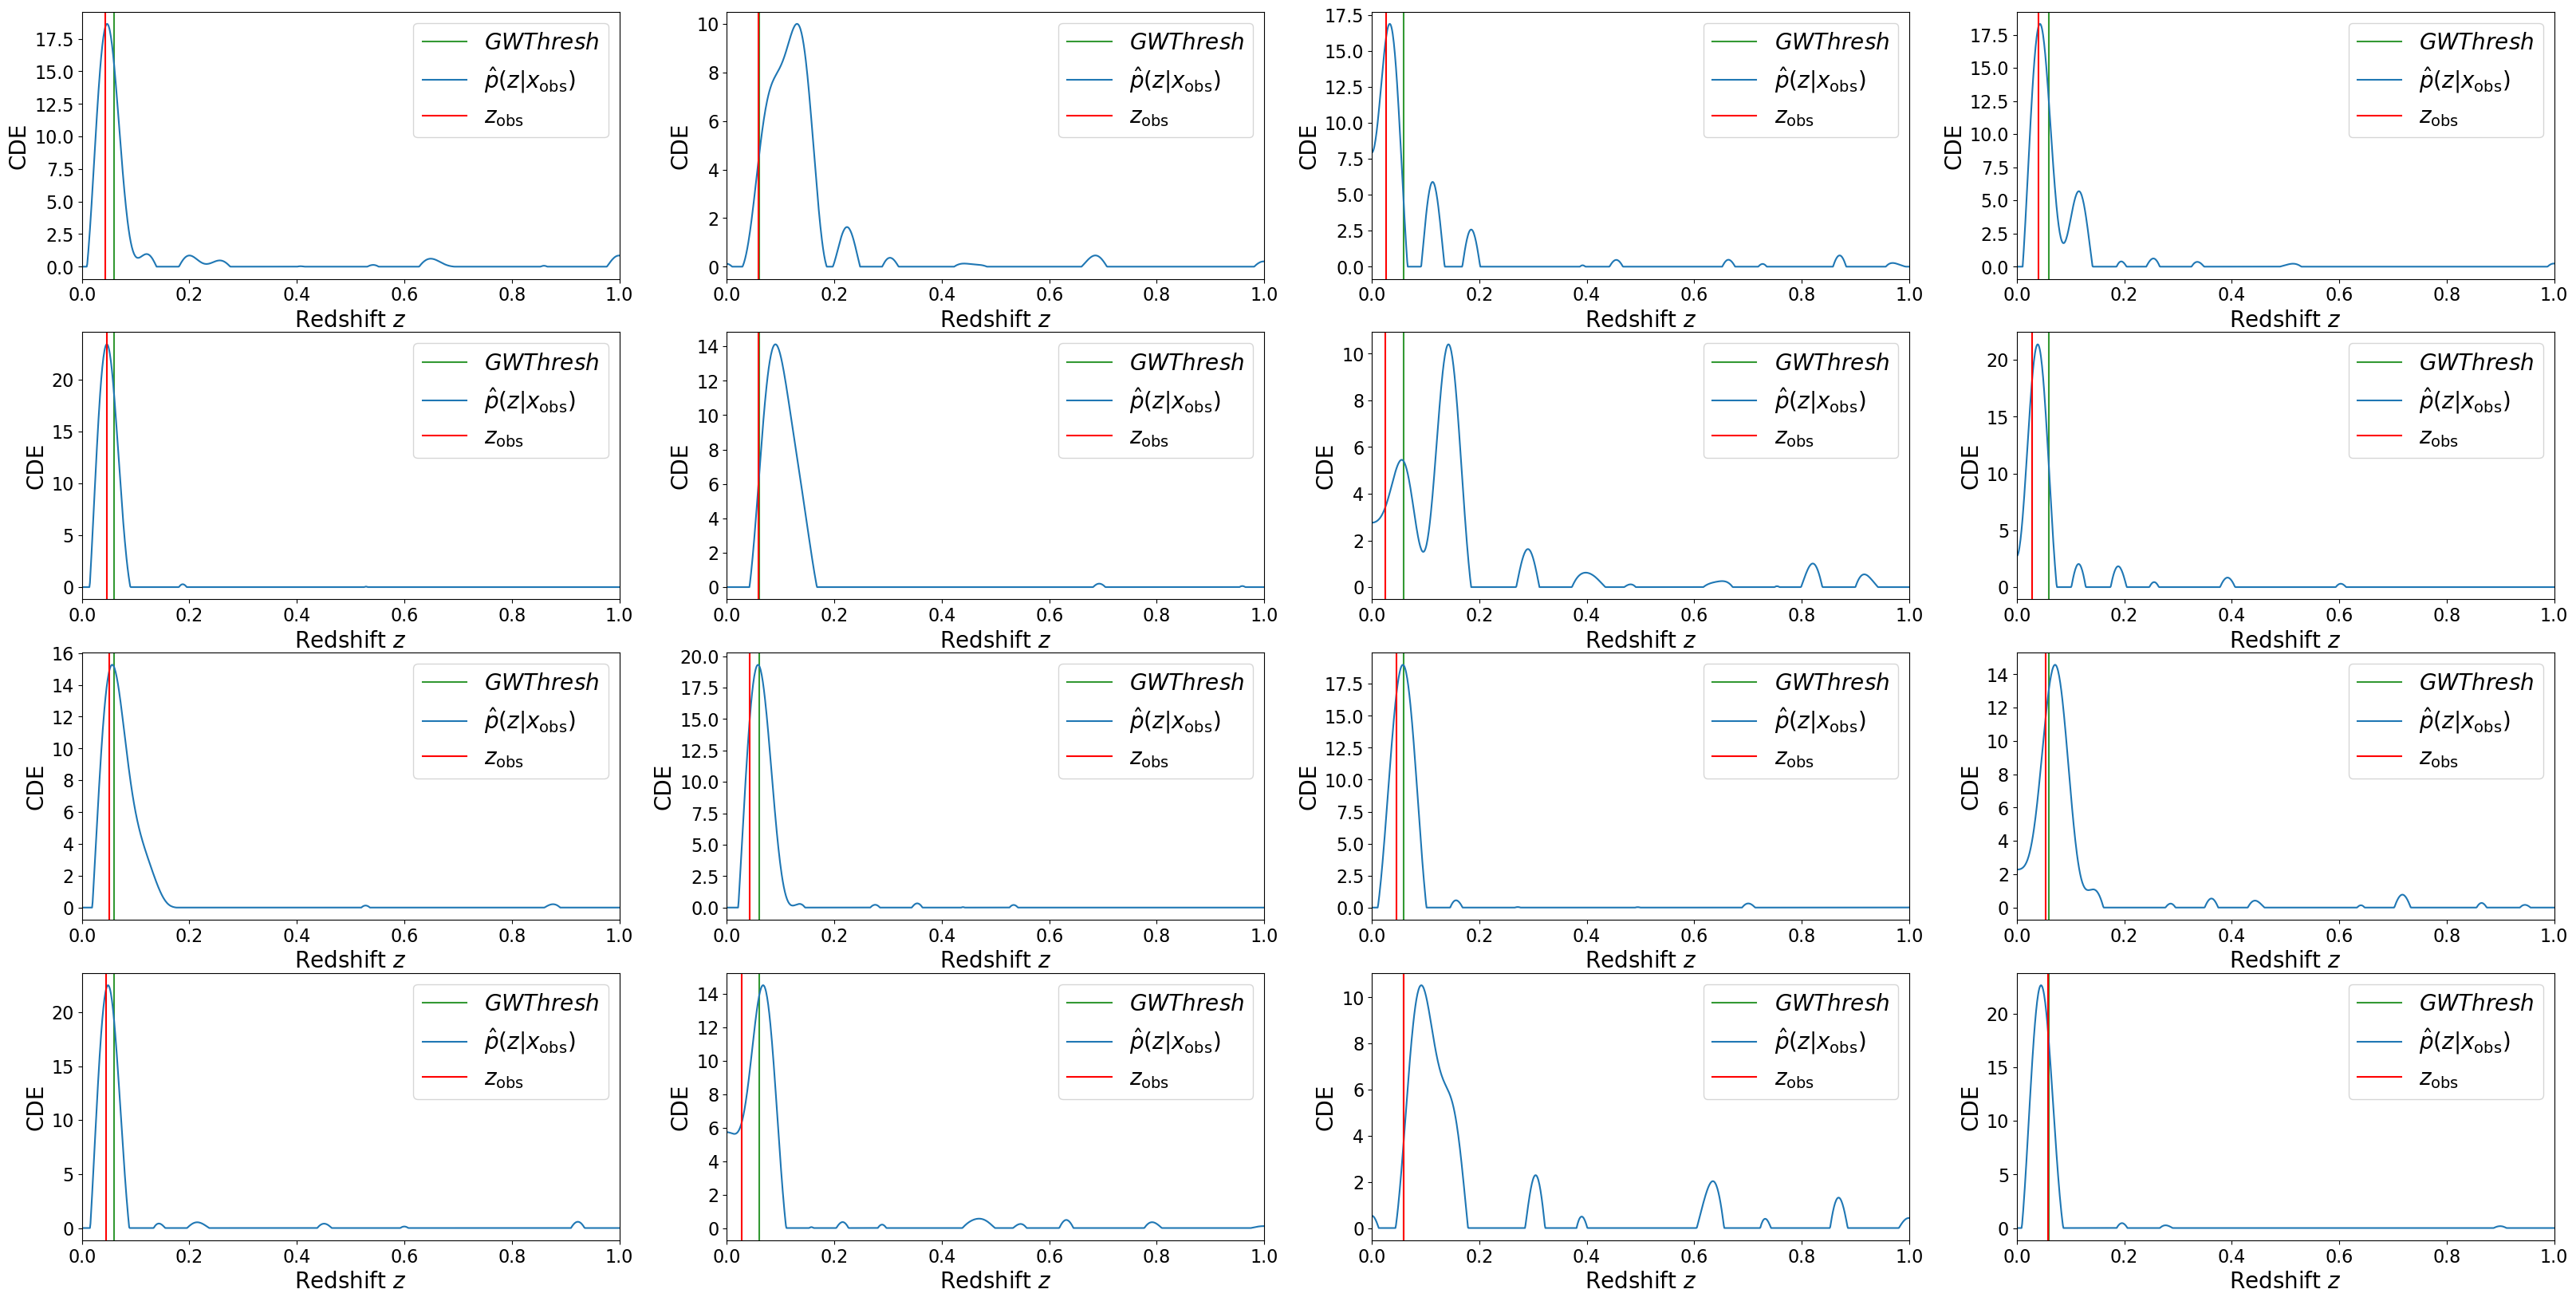

In [24]:
plot_cde_range(ps_cdes, pd.DataFrame(y_test, columns=["z"]), ps_zgrid, [0,0.06], [4,4])

Target Variable Between 0.06 - 10

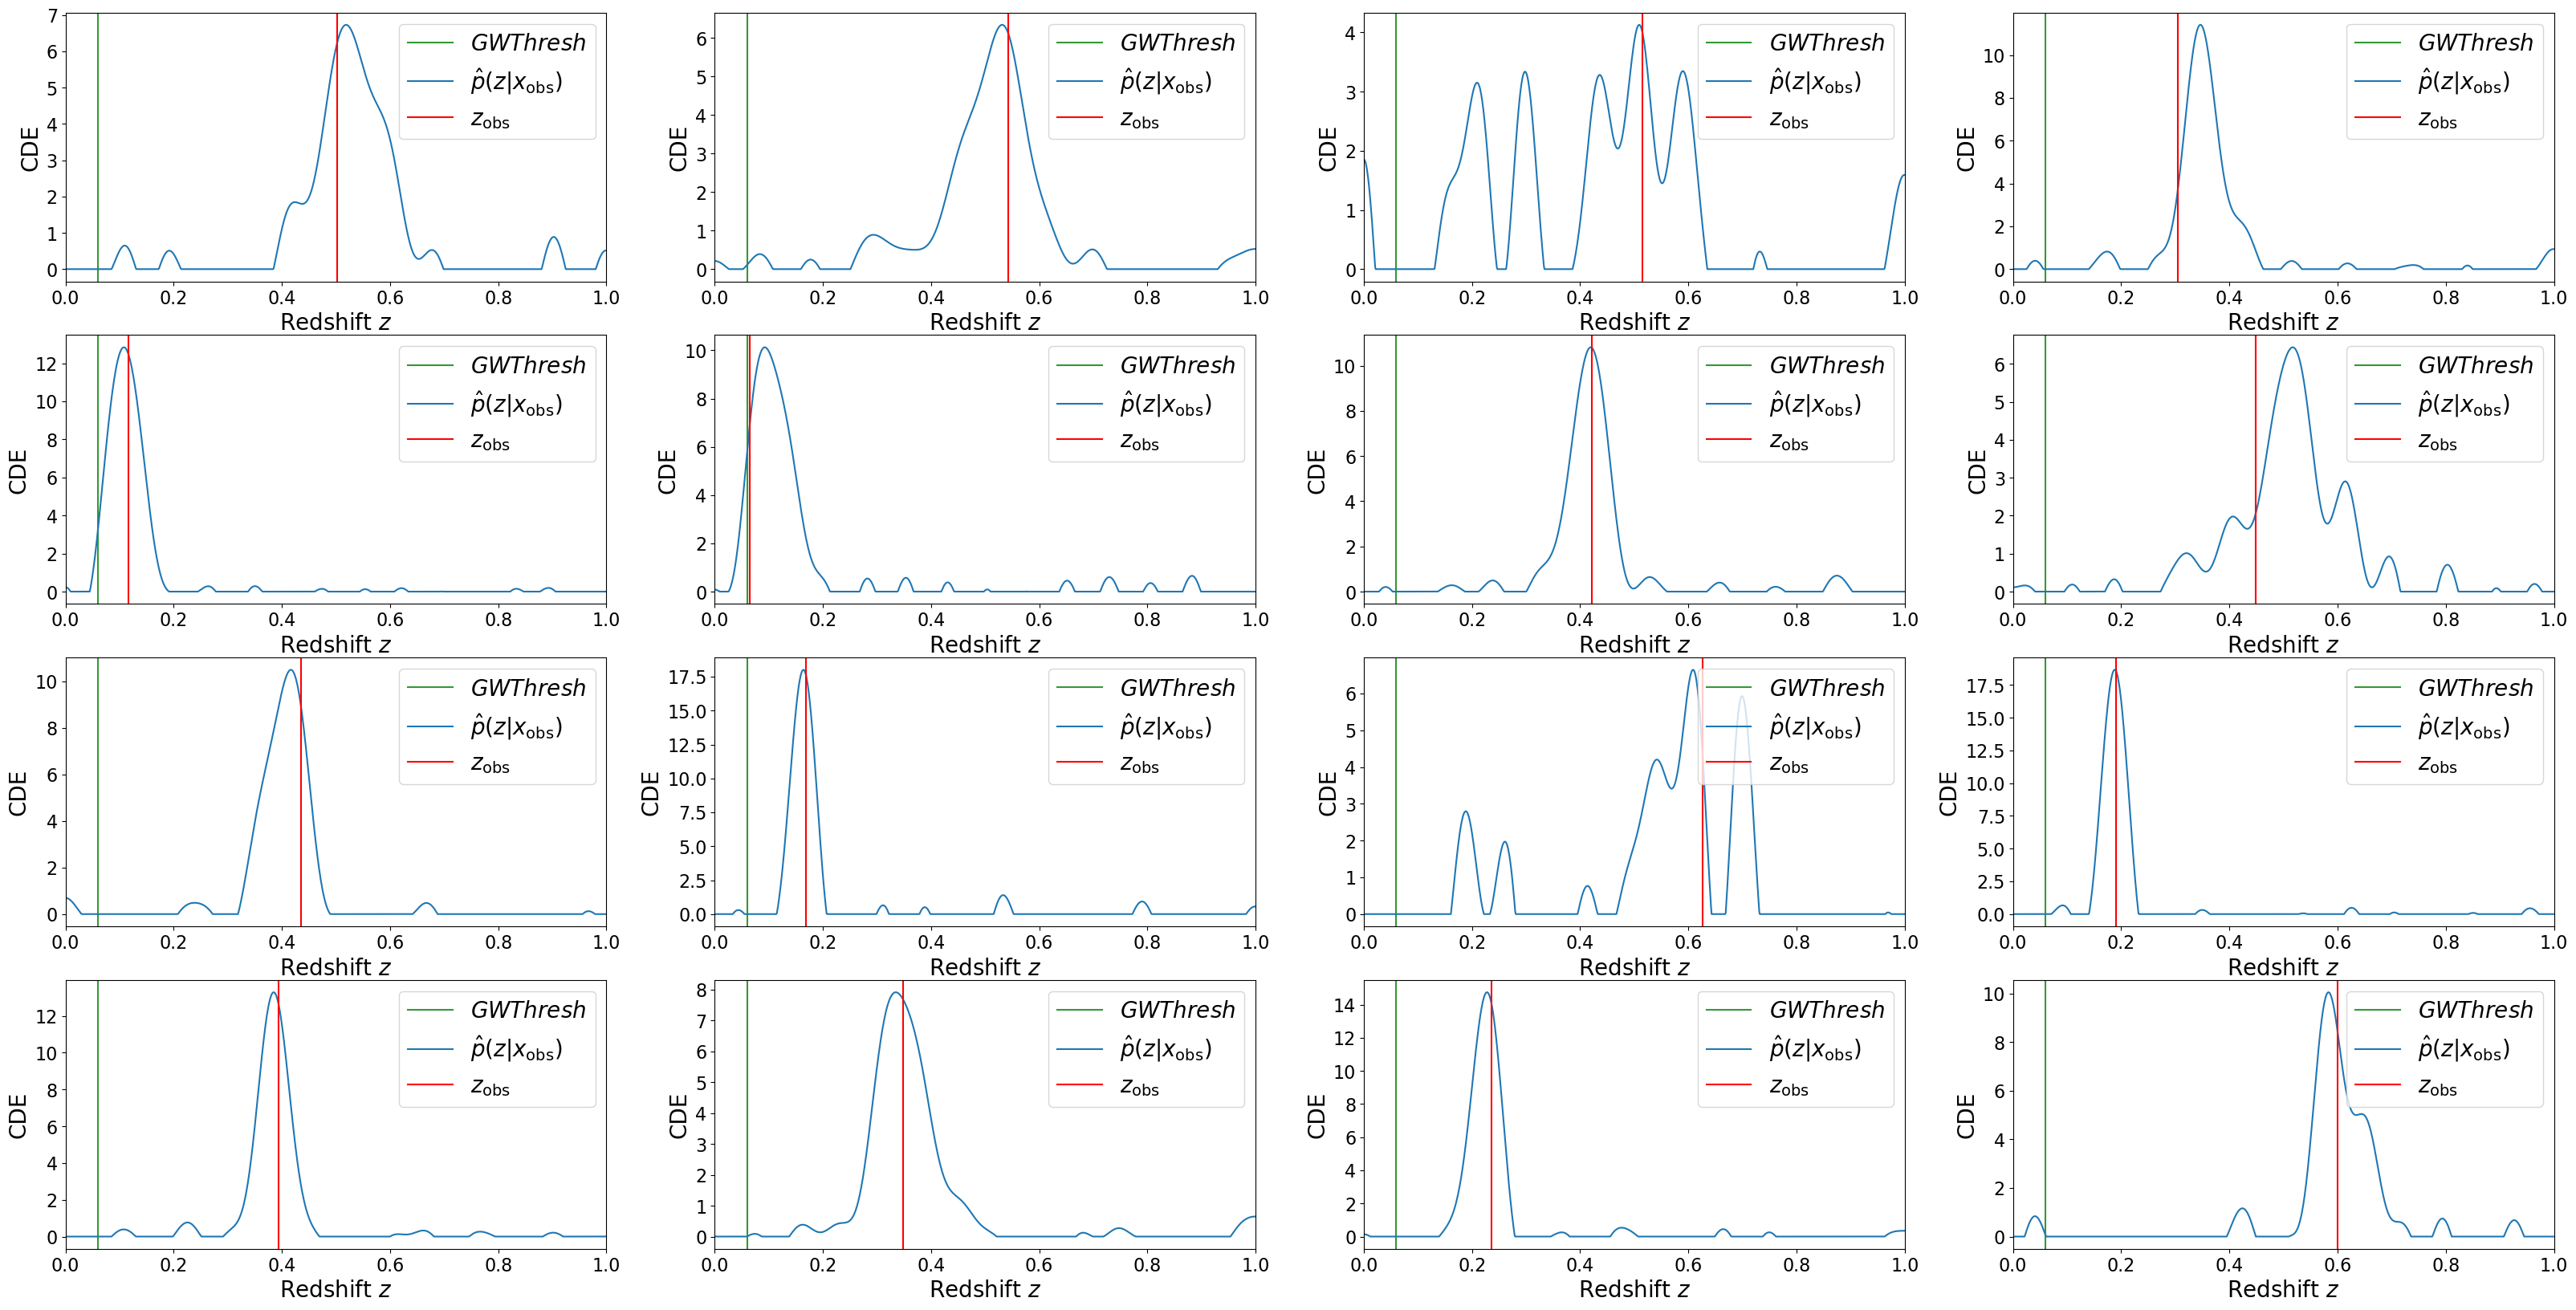

In [25]:
plot_cde_range(ps_cdes, pd.DataFrame(y_test, columns=["z"]), ps_zgrid, [0.06,10], [4,4])

### Sample CDEs from PS 2MASS Model

Target Variable Between 0 - 0.06

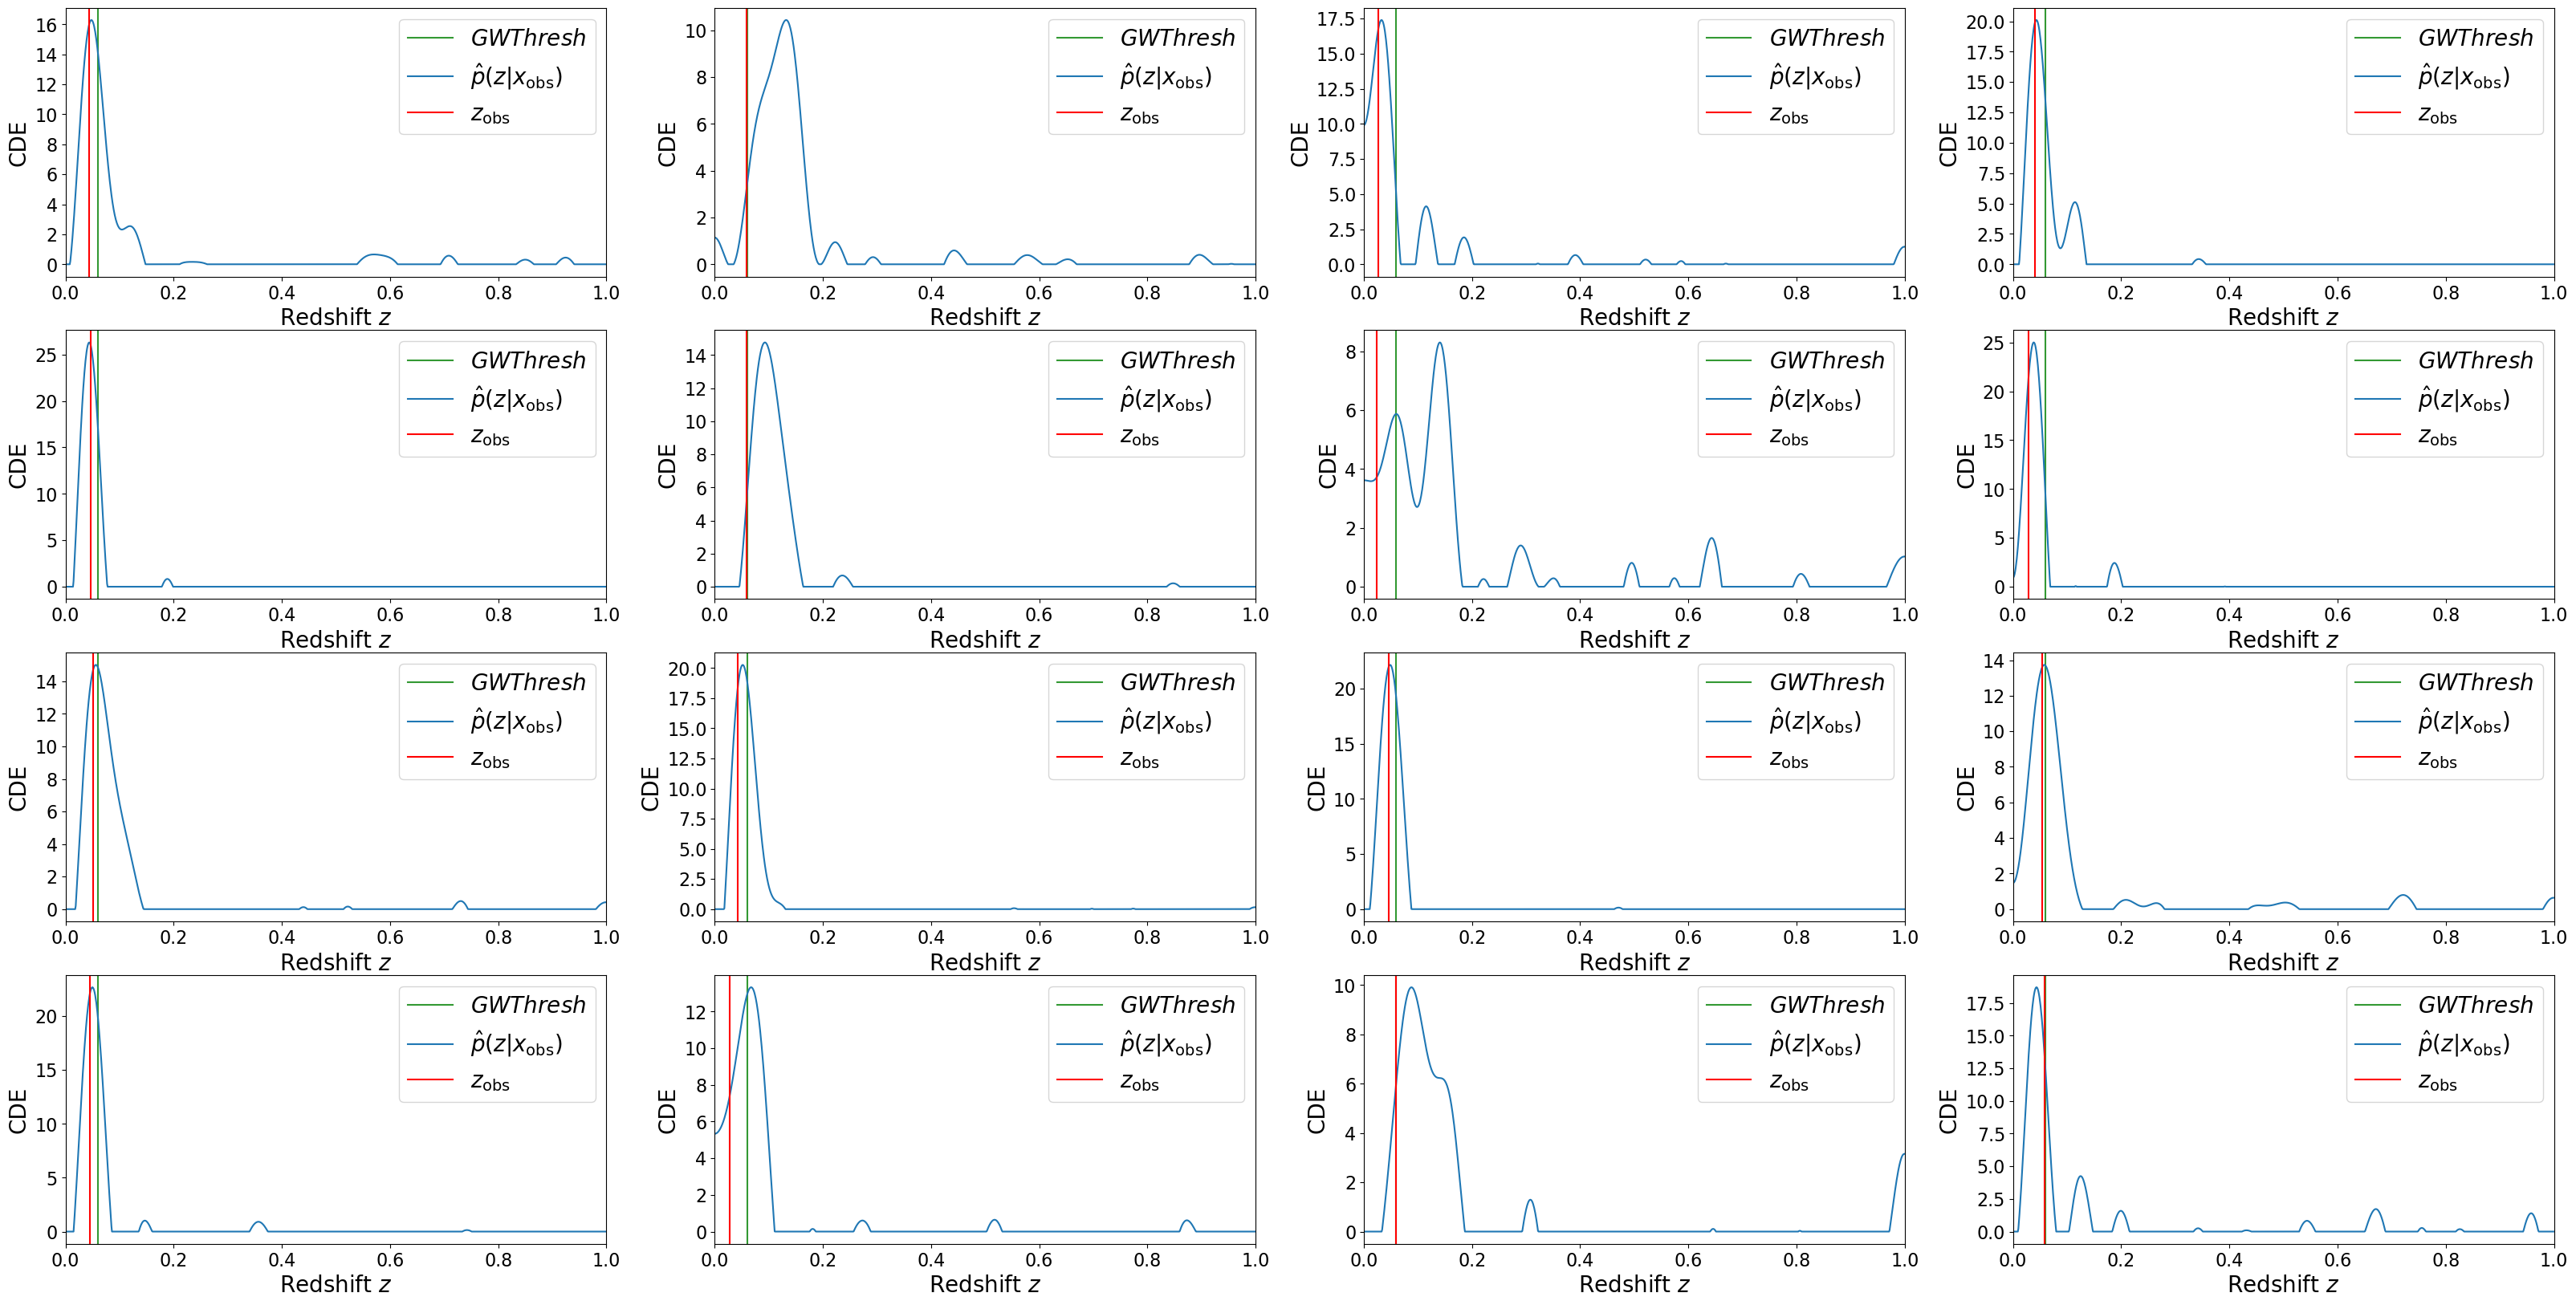

In [26]:
plot_cde_range(ps2m_cdes, pd.DataFrame(y_test, columns=["z"]), ps_zgrid, [0, 0.06], [4,4])

Target Variable Between 0.06 - 10

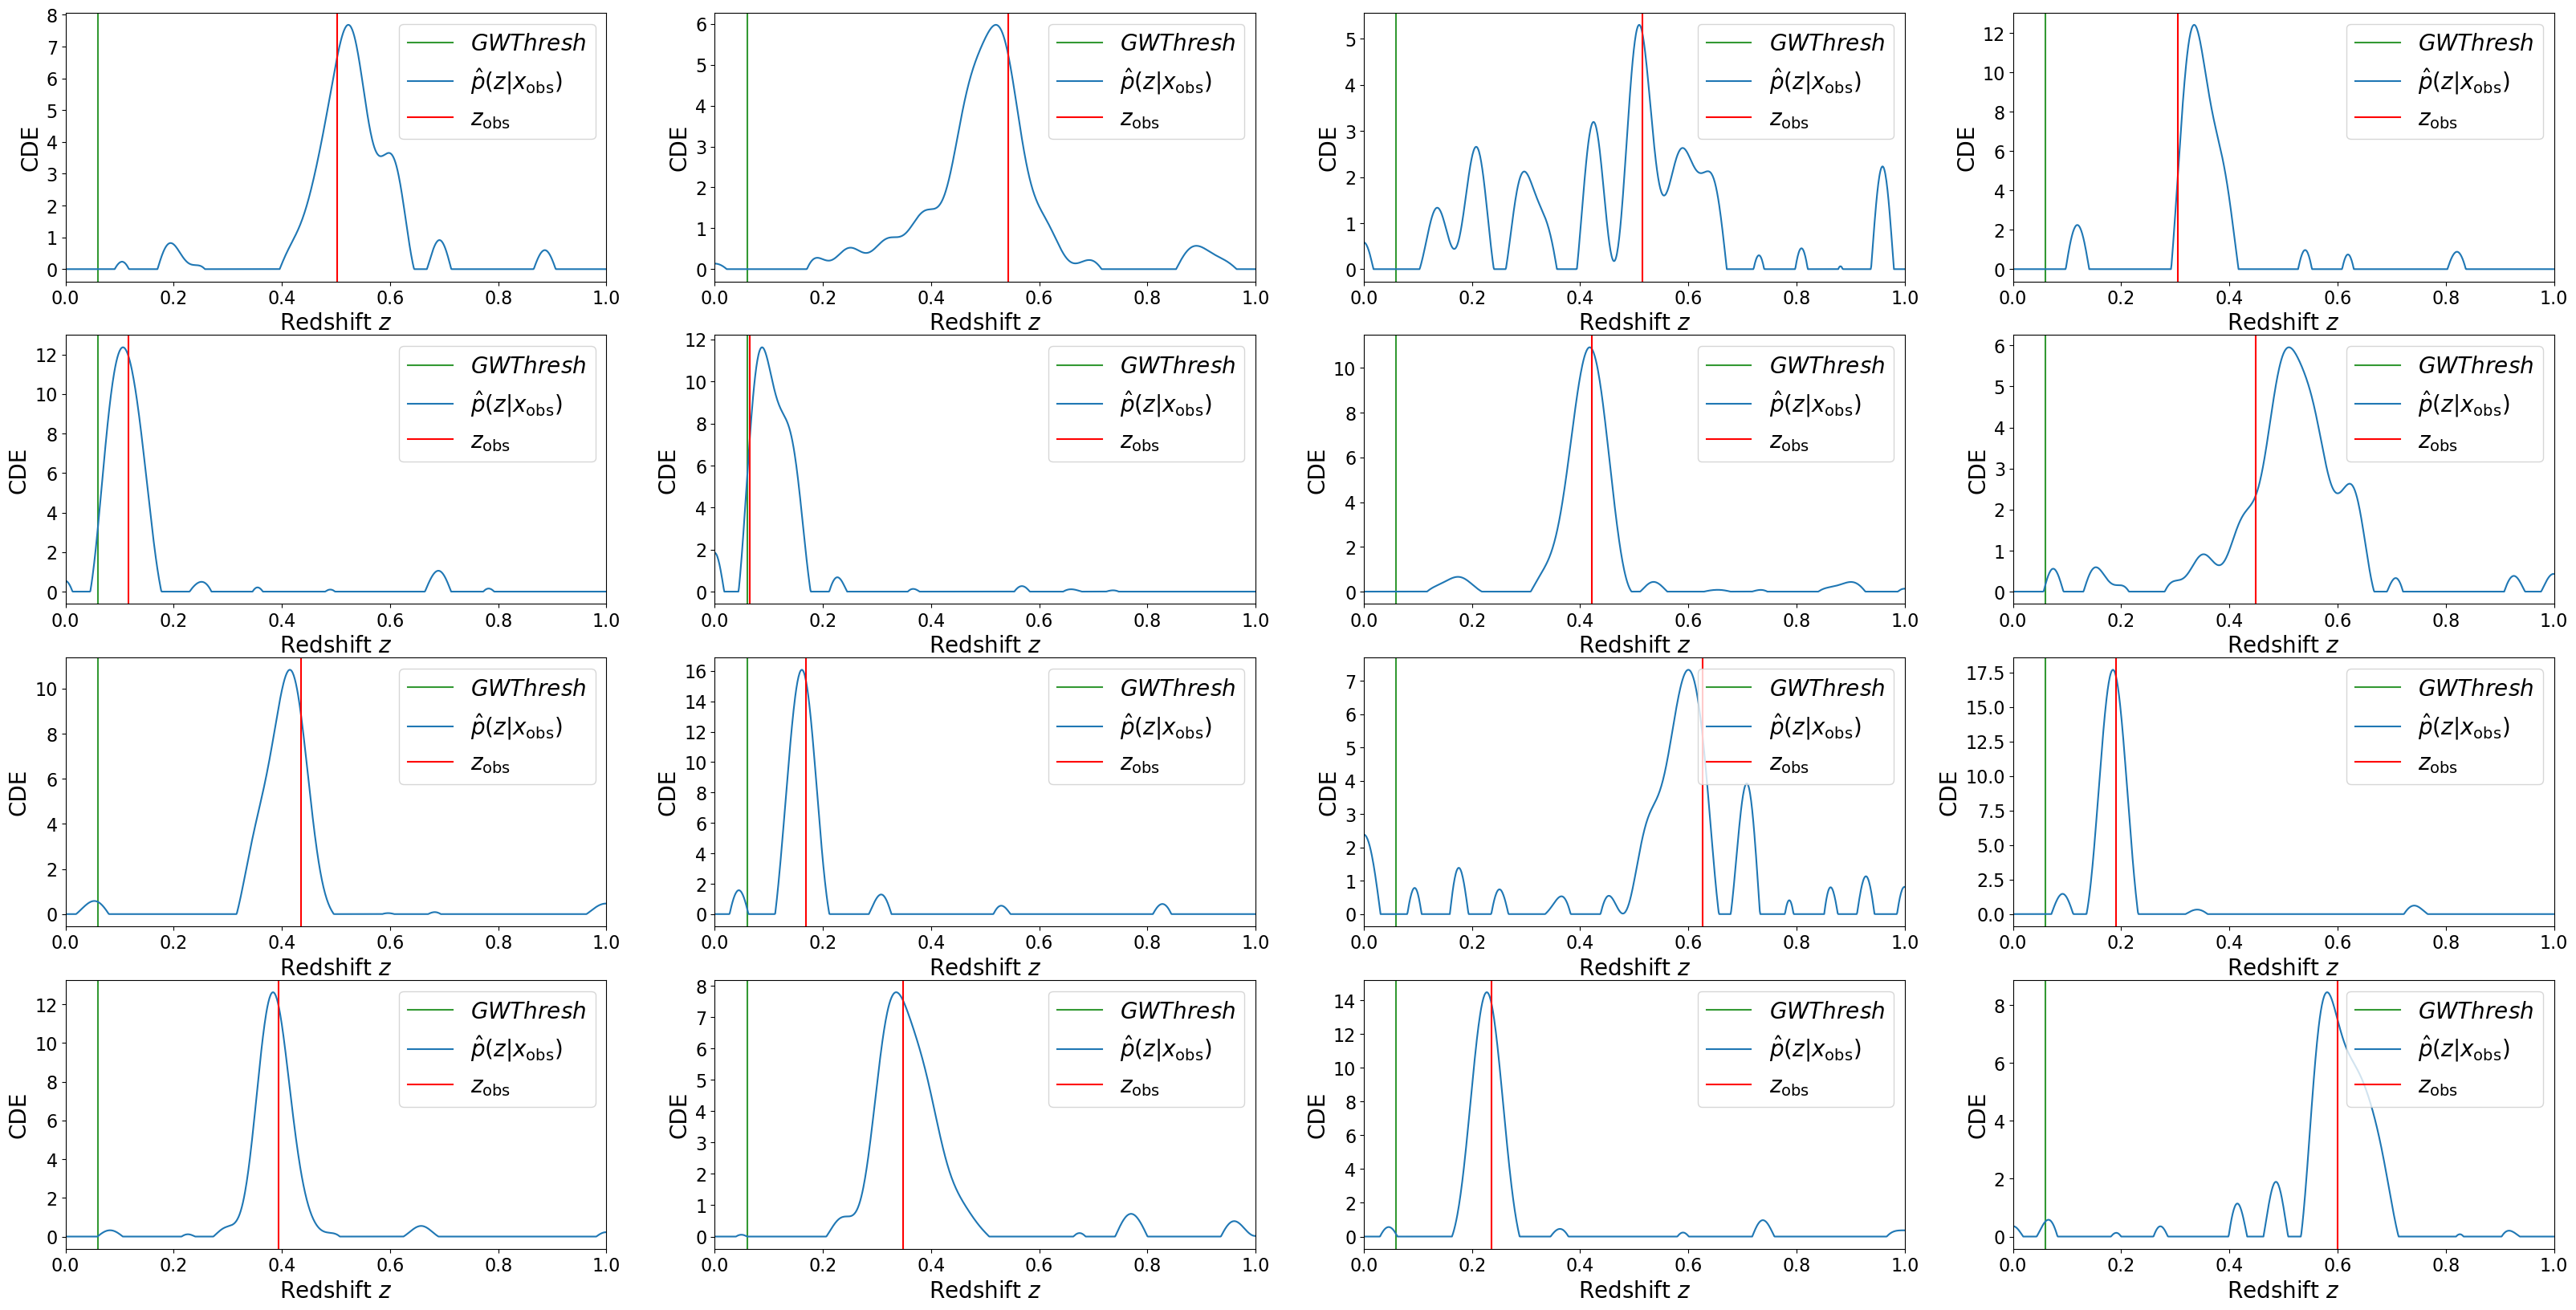

In [27]:
plot_cde_range(ps2m_cdes, pd.DataFrame(y_test, columns=["z"]), ps_zgrid, [0.06,10], [4,4])

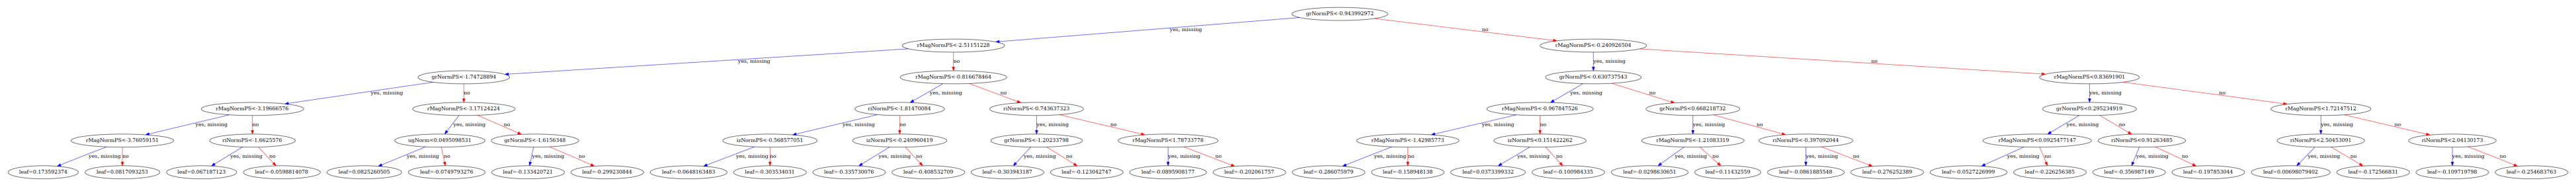

In [28]:
plot_tree(psModel.model.models.estimators_[8])
fig = plt.gcf()
fig.set_size_inches(50, 50)

In [29]:
psModel.__dict__

{'max_basis': 30,
 'best_basis': range(0, 30),
 'basis_system': 'cosine',
 'model': <flexcode.regression_models.CustomModel at 0x7f4a4bed8ed0>,
 'z_min': array([2.342765e-06]),
 'z_max': array([0.999019]),
 'bump_threshold': None,
 'sharpen_alpha': None}

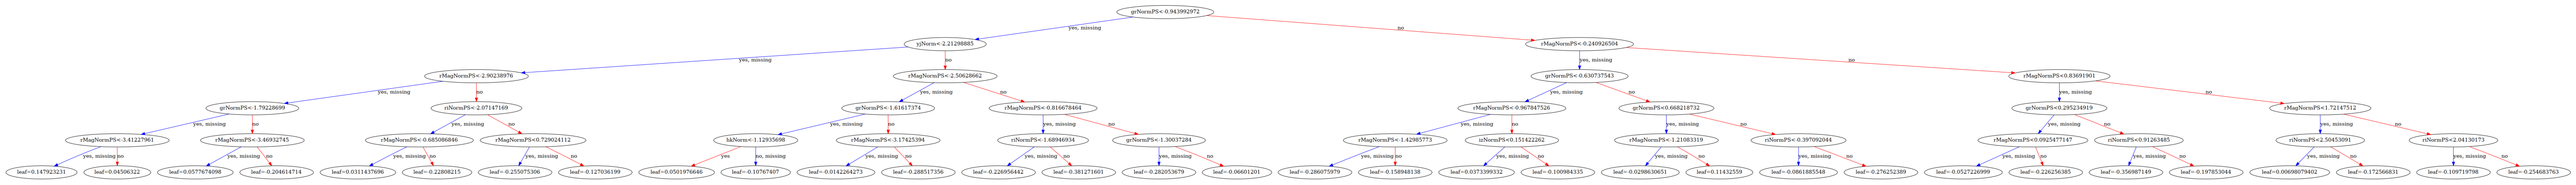

In [30]:
plot_tree(ps2mModel.model.models.estimators_[8])
fig = plt.gcf()
fig.set_size_inches(75, 50)

In [31]:
ps2mModel.__dict__

{'max_basis': 30,
 'best_basis': range(0, 30),
 'basis_system': 'cosine',
 'model': <flexcode.regression_models.CustomModel at 0x7f4a4bef4810>,
 'z_min': array([2.342765e-06]),
 'z_max': array([0.999019]),
 'bump_threshold': None,
 'sharpen_alpha': None}

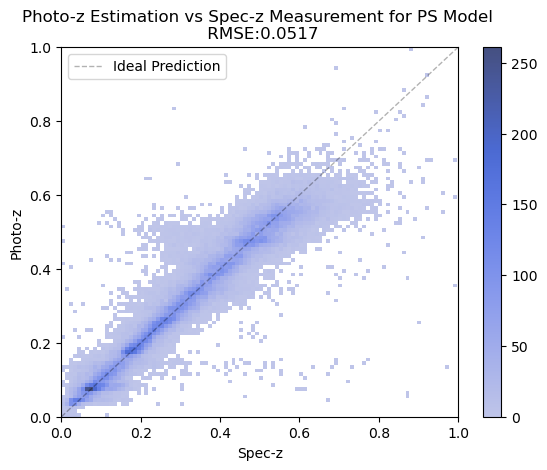

In [32]:
y_pred_ps = [ps_zgrid[cde.tolist().index(max(cde))][0] for cde in ps_cdes]
rmse_ps = mean_squared_error(y_test, y_pred_ps, squared=False)

sns.histplot(x=y_test, y=y_pred_ps, bins=100, cbar=True, color="royalblue")
plt.xlabel("Spec-z")
plt.ylabel("Photo-z")
plt.plot([0,1],[0,1], "k--", alpha=0.3, linewidth=1, label="Ideal Prediction")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.title(f"Photo-z Estimation vs Spec-z Measurement for PS Model \n RMSE:{round(rmse_ps,4)}")
plt.show()

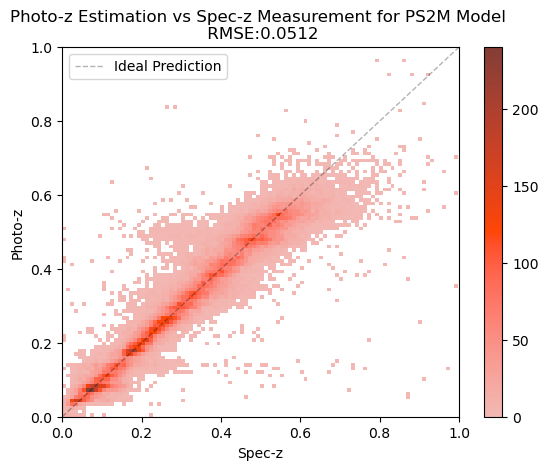

In [33]:
y_pred_ps2m = [ps2m_zgrid[cde.tolist().index(max(cde))][0] for cde in ps2m_cdes]
rmse_ps2m = mean_squared_error(y_test, y_pred_ps2m, squared=False)

sns.histplot(x=y_test, y=y_pred_ps2m, bins=100, cbar=True, color="orangered")
plt.xlabel("Spec-z")
plt.ylabel("Photo-z")
plt.plot([0,1],[0,1], "k--", alpha=0.3, linewidth=1, label="Ideal Prediction")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.title(f"Photo-z Estimation vs Spec-z Measurement for PS2M Model \n RMSE:{round(rmse_ps2m,4)}")
plt.show()

# Trying Just PanSTARRS Features

In [38]:
ps1_train = x_train[["rMagNormPS","grNormPS","riNormPS","izNormPS","zyNormPS"]]
ps1_test = x_test[["rMagNormPS","grNormPS","riNormPS","izNormPS","zyNormPS"]]

In [39]:
regression_params = {"max_depth":5}
ps1Model = flexcode.FlexCodeModel(CustomModel, max_basis=30, basis_system="cosine", custom_model=XGBRegressor, regression_params=regression_params)

In [40]:
ps1Model.fit(ps1_train, y_train)

In [41]:
n_grid = 1000

ps1_cdes, ps1_zgrid = ps1Model.predict(ps1_test, n_grid=n_grid)

ps1model_loss, std_ps1Model_loss = cde_loss(ps1_cdes, ps1_zgrid, y_test)

ps1Model_pitVals = cdf_coverage(ps1_cdes, ps1_zgrid, y_test)
ps1Model_hpdVals = hpd_coverage(ps1_cdes, ps1_zgrid, y_test)

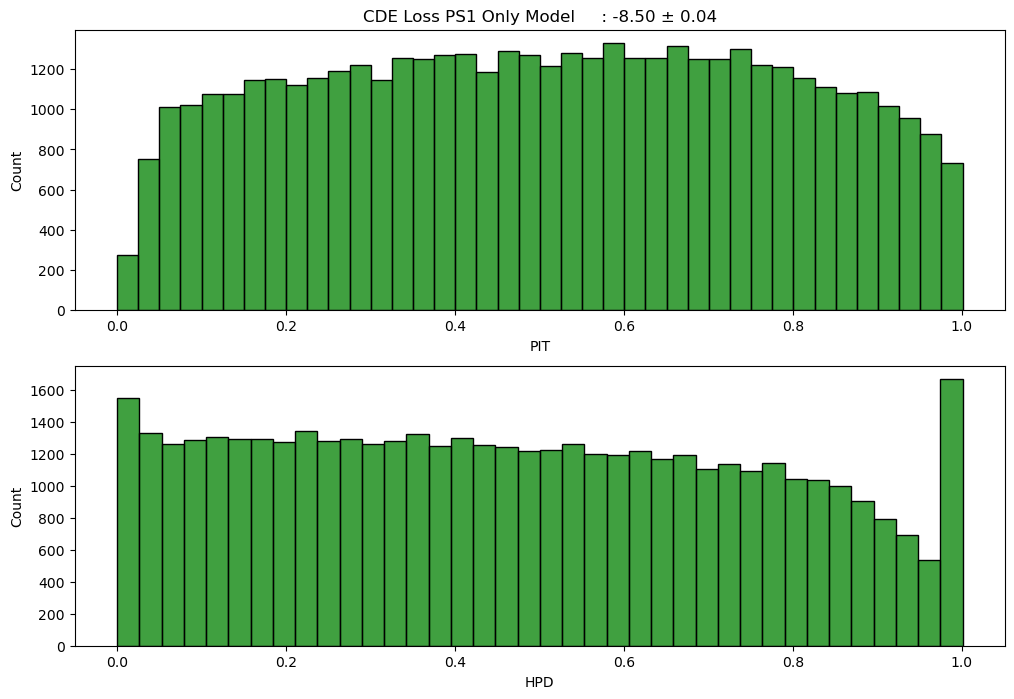

In [44]:
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

axs[0].set_title(('CDE Loss PS1 Only Model     : %4.2f ± %.2f' % (ps1model_loss, std_ps1Model_loss)))
sns.histplot(ps1Model_pitVals, ax=axs[0], color="green")
sns.histplot(ps1Model_hpdVals, ax=axs[1], color="green")
axs[0].set_xlabel("PIT")
axs[1].set_xlabel("HPD")

plt.show()

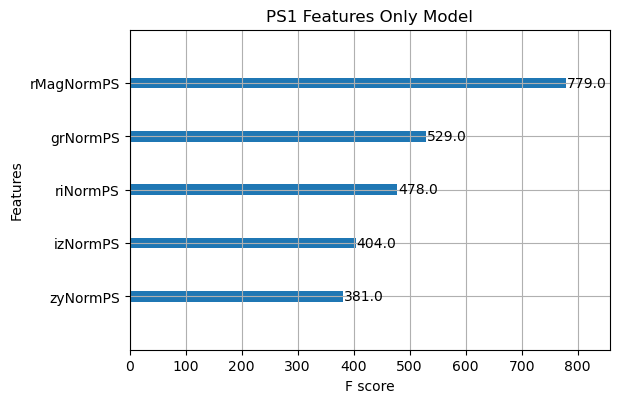

In [49]:
fig, axs = plt.subplots(ncols=1, figsize=[6,4])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plot_importance(ps1Model.model.models.estimators_[2], importance_type="weight" , ax=axs)

axs.set_title("PS1 Features Only Model")

plt.show()

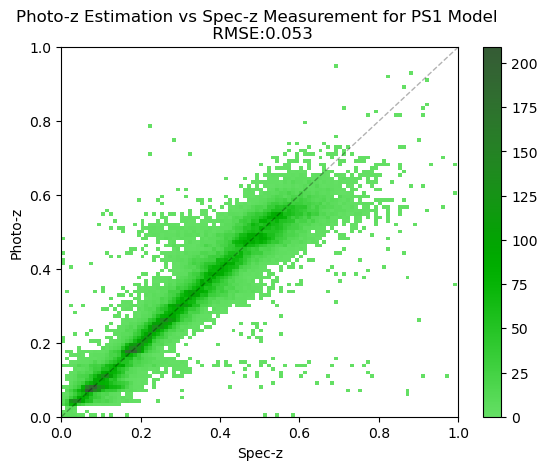

In [57]:
y_pred_ps1 = [ps1_zgrid[cde.tolist().index(max(cde))][0] for cde in ps1_cdes]
rmse_ps1 = mean_squared_error(y_test, y_pred_ps1, squared=False)

sns.histplot(x=y_test, y=y_pred_ps1, bins=100, cbar=True, color="green")
plt.xlabel("Spec-z")
plt.ylabel("Photo-z")
plt.plot([0,1],[0,1], "k--", alpha=0.3, linewidth=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Photo-z Estimation vs Spec-z Measurement for PS1 Model \n RMSE:{round(rmse_ps1,4)}")
plt.show()

## Saving Model

In [34]:
import pickle

In [55]:
# save the model to disk
filename = 'ps_spec_model.sav'
pickle.dump(ps1Model, open(filename, 'wb'))

In [21]:
np.count_nonzero(y_test>1)

0